#Face Recognition using Deep Learning (IoT project)

In [0]:
!pip install tensorflow==1.8

  Using cached https://files.pythonhosted.org/packages/22/c6/d08f7c549330c2acc1b18b5c1f0f8d9d2af92f54d56861f331f372731671/tensorflow-1.8.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/59/a6/0ae6092b7542cfedba6b2a1c9b8dceaf278238c39484f3ba03b03f07803c/tensorboard-1.8.0-py3-none-any.whl
ERROR: -ensorflow 1.13.1 has requirement tensorboard<1.14.0,>=1.13.0, but you'll have tensorboard 1.8.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.8.0 which is incompatible.
  Found existing installation: tensorboard 1.11.0
    Uninstalling tensorboard-1.11.0:
      Successfully uninstalled tensorboard-1.11.0
  Found existing installation: tensorflow 1.11.0
    Uninstalling tensorflow-1.11.0:
      Successfully uninstalled tensorflow-1.11.0


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile
import keras
from keras.applications import MobileNet
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
print(keras.__version__)

2.2.4


Using TensorFlow backend.


##Build dataset 

We have taken photos of our group members mixed with  public face dataset . I took a video of the landmarks and used FFmpeg to extract 4 images(frames) per second. Finally I shuffle the dataset and split them into train, validation and test dataset.

In [0]:
!ls 

face  face.zip	model1.h5  model.h5  sample_data


In [0]:
local_zip = 'face.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('face')
zip_ref.close()
base_dir = 'face'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_owner_dir = os.path.join(train_dir, 'owner')
train_breaker_dir = os.path.join(train_dir, 'breaker')

validation_owner_dir = os.path.join(validation_dir, 'owner')
validation_breaker_dir = os.path.join(validation_dir, 'breaker')


test_owner_dir = os.path.join(test_dir, 'owner')
test_breaker_dir = os.path.join(test_dir, 'breaker')

In [0]:
num_owner_tr = len(os.listdir(train_owner_dir))
num_breaker_tr = len(os.listdir(train_breaker_dir))

num_owner_val = len(os.listdir(validation_owner_dir))
num_breaker_val = len(os.listdir(validation_breaker_dir))

num_owner_test = len(os.listdir(test_owner_dir))
num_breaker_test = len(os.listdir(test_breaker_dir))

total_train = num_owner_tr + num_breaker_tr
total_val = num_owner_val + num_breaker_val
total_test = num_owner_test + num_breaker_test

In [0]:
print('Training owner images:', num_owner_tr)
print('Training breaker images:', num_breaker_tr)

print('Validation owner images:', num_owner_val)
print('Validation breaker images:', num_breaker_val)


print('Test owner images:', num_owner_test)
print('Test breaker images:', num_breaker_test)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

Training owner images: 734
Training breaker images: 720
Validation owner images: 34
Validation breaker images: 116
Test owner images: 5
Test breaker images: 3
--
Total training images: 1454
Total validation images: 150
Total test images: 8


##Data augmentation

In [0]:
TARGET_SHAPE = 160 
BATCH_SIZE = 32


image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='binary')


image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='binary')


image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='binary')

Found 1454 images belonging to 2 classes.
Found 148 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


## Display Sample Training Images

In [0]:
sample_training_images, sample_training_labels = next(train_data_gen)


In [0]:

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

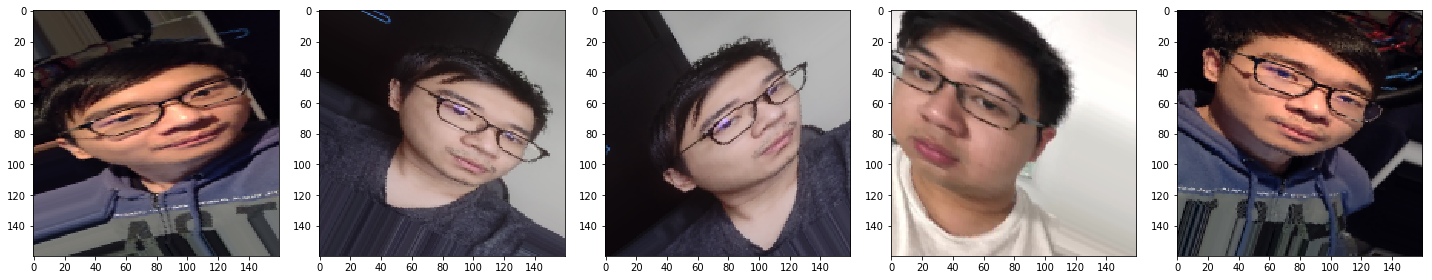

In [0]:

plotImages(sample_training_images[:5])

# Part2 transfer learning
First I chosen MobileNet as the model, and I apply the transfer learning onto the Mobilenet model trained on my own Dataset.

In [0]:

vgg16_conv_base = MobileNet(weights='imagenet',include_top=False, input_shape=(160, 160, 3))


In [0]:
vgg16_conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 161, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 80, 80, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 80, 80, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 80, 80, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 80, 80, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 80, 80, 32)        128       
__________

In [0]:

vgg16_conv_base.trainable = False
vgg16_model = Sequential()
vgg16_model.add(vgg16_conv_base)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(512, activation='relu'))
vgg16_model.add(Dense(1, activation='sigmoid'))

In [0]:
vgg16_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Model)   (None, 5, 5, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               13107712  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 16,337,089
Trainable params: 13,108,225
Non-trainable params: 3,228,864
_________________________________________________________________


In [0]:
EPOCHS = 5


In [0]:

vgg16_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])


vgg16_history = vgg16_model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=1)

Epoch 1/5
46/46 [==============================] - 226s 5s/step - loss: 1.5821 - acc: 0.8852 - val_loss: 0.0071 - val_acc: 0.9932
Epoch 2/5
46/46 [==============================] - 215s 5s/step - loss: 0.1221 - acc: 0.9915 - val_loss: 2.8203e-06 - val_acc: 1.0000
Epoch 3/5
46/46 [==============================] - 218s 5s/step - loss: 0.0655 - acc: 0.9946 - val_loss: 0.2196 - val_acc: 0.9527
Epoch 4/5
46/46 [==============================] - 218s 5s/step - loss: 0.0766 - acc: 0.9939 - val_loss: 1.0428e-07 - val_acc: 1.0000
Epoch 5/5
46/46 [==============================] - 218s 5s/step - loss: 0.0108 - acc: 0.9993 - val_loss: 1.0428e-07 - val_acc: 1.0000


## Plot Training and Validation Loss and Accuracy

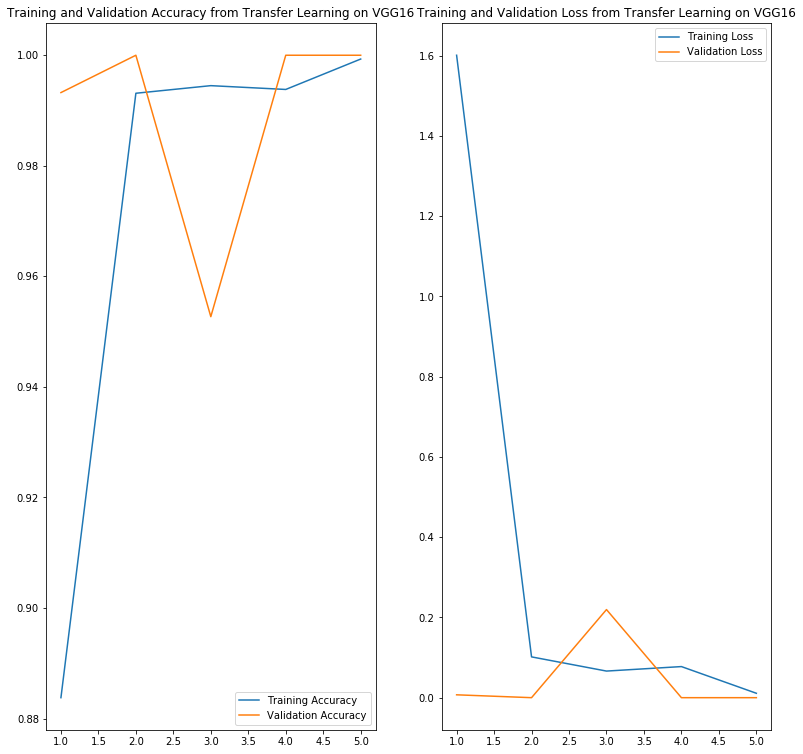

In [0]:
acc = vgg16_history.history['acc']
val_acc = vgg16_history.history['val_acc']

loss = vgg16_history.history['loss']                                              
val_loss = vgg16_history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(13,13))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy from Transfer Learning on VGG16')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss from Transfer Learning on VGG16')
plt.show()

## Show Testing Loss and Accuracy

In [0]:
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_data_gen, verbose=1)

AttributeError: ignored

In [0]:
print('The test loss is '+ str(round(vgg16_test_loss,2))+' and the test accracy is '+ str(round(vgg16_test_accuracy,2)))

In [0]:
vgg16_model.save("model1.h5")

#part3: self-defined CNN

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32


image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='binary')


image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=validation_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='binary')


image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='binary')

Found 1454 images belonging to 2 classes.
Found 148 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [0]:
inc_model = Sequential()
inc_model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(480, 480, 3)))
inc_model.add(MaxPooling2D((2, 2)))
inc_model.add(Conv2D(64, (3, 3), activation='relu'))
inc_model.add(MaxPooling2D((2, 2)))
inc_model.add(Conv2D(128, (3, 3), activation='relu'))
inc_model.add(MaxPooling2D((2, 2)))
inc_model.add(Conv2D(128, (3, 3), activation='relu'))
inc_model.add(MaxPooling2D((2, 2)))
inc_model.add(Flatten())
inc_model.add(Dense(512, activation='relu'))
inc_model.add(Dense(1, activation='sigmoid'))

In [0]:
EPOCHS = 10
inc_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# Train Transfer Learning
inc_history = inc_model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=1)

Epoch 1/10
46/46 [==============================] - 133s 3s/step - loss: 0.2619 - acc: 0.8770 - val_loss: 1.5354e-05 - val_acc: 1.0000
Epoch 2/10
46/46 [==============================] - 132s 3s/step - loss: 0.0361 - acc: 0.9898 - val_loss: 4.4429e-05 - val_acc: 1.0000
Epoch 3/10
46/46 [==============================] - 129s 3s/step - loss: 0.0073 - acc: 0.9980 - val_loss: 1.5738e-06 - val_acc: 1.0000
Epoch 4/10
46/46 [==============================] - 130s 3s/step - loss: 0.0228 - acc: 0.9932 - val_loss: 1.0015e-06 - val_acc: 1.0000
Epoch 5/10
46/46 [==============================] - 132s 3s/step - loss: 0.0050 - acc: 0.9993 - val_loss: 1.0428e-07 - val_acc: 1.0000
Epoch 6/10
46/46 [==============================] - 128s 3s/step - loss: 0.0126 - acc: 0.9973 - val_loss: 3.7972e-06 - val_acc: 1.0000
Epoch 7/10
46/46 [==============================] - 131s 3s/step - loss: 0.0057 - acc: 0.9980 - val_loss: 1.1362e-07 - val_acc: 1.0000
Epoch 8/10
46/46 [==============================] - 128

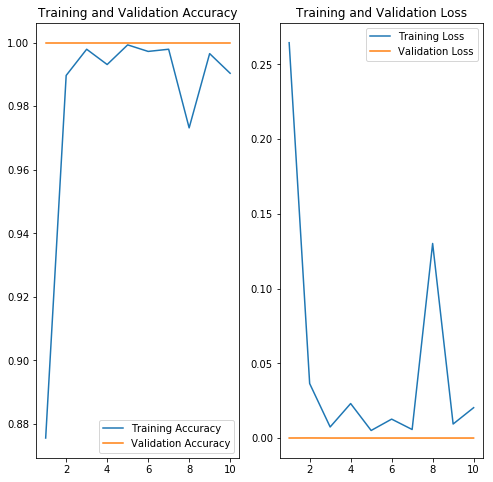

In [0]:
acc = inc_history.history['acc']
val_acc = inc_history.history['val_acc']

loss = inc_history.history['loss']
val_loss = inc_history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
inc_test_loss, inc_test_accuracy = inc_model.evaluate(test_data_gen, verbose=1)
print('The test loss is '+ str(round(inc_test_loss,2))+' and the test accracy is '+ str(round(inc_test_accuracy,2)))

AttributeError: ignored

In [0]:
inc_model.save_weights("model.h5")

In [0]:
import PIL
from PIL import Image
img = Image.open("/content/face/test/owner/IMG_20190428_164249.jpg")
img = img.resize((150,150), PIL.Image.ANTIALIAS)
image = np.asarray(img)
shape1 = image.shape
print(shape1)
image = np.expand_dims(image, axis=0)
print(image.shape)
result = inc_model.predict(image)
print(result)


(150, 150, 3)
(1, 150, 150, 3)
[[1.]]
